# TMSE - $\lambda$ coordinates

In [1]:
#install.packages("SphericalCubature")
library("SphericalCubature")
help("rect2polar")

Le chargement a nécessité le package : cubature

Le chargement a nécessité le package : SimplicialCubature

Le chargement a nécessité le package : mvmesh

Le chargement a nécessité le package : rcdd

If you want correct answers, use rational arithmetic.
See the Warnings sections in help pages for
    functions that do computational geometry.

Le chargement a nécessité le package : rgl

Le chargement a nécessité le package : geometry

Le chargement a nécessité le package : abind



In [2]:
data<-read.csv("data_visco.csv")
data_lasso <- read.csv("data_lasso.csv")
data_AIC <- read.csv("data_AIC.csv")

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“Fin de fichier (EOF) dans une chaîne de caractères entre guillements”


### Change of  variables from a simplex to a N-sphere with the N-sphere coordinates

In [3]:
change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    epsilon<-1e-9  # We had a little noise to insure that we can devide by 0
    X<-as.matrix(x[, -1]/100)
    X[which(X == NaN)] <- 0.
    for (i in 1:dim(X)[1]){   #To ensure that we each row is equal to 1 to remove the noise in the column with the highest values in it
        X[ i,23] <- X[ i,23] - (sum(X[i, ]==0.))*epsilon
    }
    X[which(X == 0.)] <- epsilon
    Y<-sqrt(X) #We do a first change of variables y²=x eq y=sqrt(x)
    Y[is.na(Y)] <- 0  #If we have some Nan in our matrix we replace them by zeros
    return(t(as.matrix(rect2polar(t(Y))$phi)))
}


### Change of  variables from a N-sphere to an simplex with the N-sphere coordinates

In [4]:
change_in_x_from_phi = function(phi){ #We put in argumennt a matrix or a vector that takes n-1 values of angles in [0, pi/2]
    Phi<-as.matrix(phi)  
    r=rep(1,dim(Phi)[1])  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, t(Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)
    new[which(new<1e-4)]<-0   #We obtain sometimes values of order 1e-5 we replace it by 0
    return (new)
}


### Change of  variables from an simplex to an hypercube with the length ratio variables

In [5]:
change_in_lambda_from_x = function(x){  # We put in argument a matrix or a vector that takes n values in a simplex
    X<-as.matrix(x)
    Phi<-change_in_phi_from_x(X) #We change our variables from the simplex in angles in [0, pi/2 ]
    lambda<-(cos(Phi))**2 # We change of varaible is the following : lambda=cos(theta)
    return(lambda)
}

### Change of  variables from an hypercube to a simplex which the length ratio variables

In [6]:
change_in_x_from_lambda = function(lambda){ #We put in argument a matrix or a vector of n-1 variables in an hypercube
    Lambda<-as.matrix(lambda) 
    Phi<-acos(sqrt(Lambda)) #We change our variables from the hypercube to the N-spheres so n-1 angles in [0, pi/2]
    return(change_in_x_from_phi(Phi)) #We use the change of variables from a N-sphere to a simplex
}

### Targeted IMSE

In [7]:
library("KrigInv") #Pour t-IMSE
library("nloptr") #Pour la fonction d'optimisation Cobyla

Le chargement a nécessité le package : DiceKriging



In [8]:
#t-IMSE STANDARD APPLIQUEE AUX DONNEES 

d = dim(data_lasso)[2]
print(d)
N = 10*d
s = 0
data_Lasso_reduced = change_in_lambda_from_x(data_lasso[1:N,-1])
data_Lasso_reduced=cbind(log(data_lasso[,1]),data_Lasso_reduced)
shape = c(dim(data_Lasso_reduced[, -1]))
print(shape)
noise = matrix(runif(prod(shape), min=0.0001, max=0.002),nrow=N)

mod = km(formula = ~1, design = data_Lasso_reduced[,-1]+noise, response = data_Lasso_reduced[,1])


lowerbound = as.vector(rep(0, dim(data_Lasso_reduced[, -1])[2]))
upperbound = as.vector(rep(1, dim(data_Lasso_reduced[, -1])[2]))
max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par


[1] 29


Warning message in sqrt(X):
“Production de NaN”
Warning message in cbind(log(data_lasso[, 1]), data_Lasso_reduced):
“number of rows of result is not a multiple of vector length (arg 1)”


[1] 290  26

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.4493045 1.497925 0.0160884 0.003769383 0.261414 0.01234772 0.003783817 0.003745744 0.003737792 0.004414118 1.05119 0.003759255 0.5796338 0.2492155 0.03599969 0.003769311 1.107281 0.003778028 0.03850249 0.003788425 1.5774 0.501522 0.1848267 0.6696026 1.003011 2.002477 
  - best initial criterion value(s) :  -563.81 

N = 26, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       563.81  |proj g|=       1.0885
At iterate     1  f =        478.1  |proj g|=       0.91604
At iterate     2  f =       413.3

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26
0.5103493,0.1788685,0.7665288,0.6669481,0.1867942,0.5849791,0.9317264,0.7290484,0.2714729,0.0830853,⋯,0.2054092,0.4141249,0.5457654,0.8873764,0.6772147,0.8064056,0.6117999,0.6344309,0.81859,0.5768061


In [9]:
lambda=max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par
lambda



Tue May 17 19:49:36 2022
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+00 
 0.000000e+00   <=  X2   <=    1.000000e+00 
 0.000000e+00   <=  X3   <=    1.000000e+00 
 0.000000e+00   <=  X4   <=    1.000000e+00 
 0.000000e+00   <=  X5   <=    1.000000e+00 
 0.000000e+00   <=  X6   <=    1.000000e+00 
 0.000000e+00   <=  X7   <=    1.000000e+00 
 0.000000e+00   <=  X8   <=    1.000000e+00 
 0.000000e+00   <=  X9   <=    1.000000e+00 
 0.000000e+00   <=  X10  <=    1.000000e+00 
 0.000000e+00   <=  X11  <=    1.000000e+00 
 0.000000e+00   <=  X12  <=    1.000000e+00 
 0.000000e+00   <=  X13  <=    1.000000e+00 
 0.000000e+00   <=  X14  <=    1.000000e+00 
 0.000000e+00   <=  X15  <=    1.000000e+00 
 0.000000e+00   <=  X16  <=    1.000000e+00 
 0.000000e+00   <=  X17  <=    1.000000e+00 
 0.000000e+00   <=  X18  <=    1.000000e+00 
 0.000000e+00   <=  X19  <=    1.000000e+00 
 0.000000e+00   <=  X20  <=    1.000000e+00 
 0.000000e+00   <=  X21  <=    1.000000e+00 
 0.000000e+00   <= 

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26
0.5103493,0.1788685,0.7665288,0.6669481,0.1867942,0.5849791,0.9317264,0.7290484,0.2714729,0.0830853,⋯,0.2054092,0.4141249,0.5457654,0.8873764,0.6772147,0.8064056,0.6117999,0.6344309,0.81859,0.5768061


In [11]:
change_in_x_from_lambda(lambda)
sum(change_in_x_from_lambda(lambda))

0.5103493,0.0875831,0.3081963,0.06260722,0.005839933,0.01487254,0.009831125,0.0005251993,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 0.9999259

In [12]:
0.7613852+0.2310616+0.00391907+0.002243488+0.001342643

[1] 0.999952

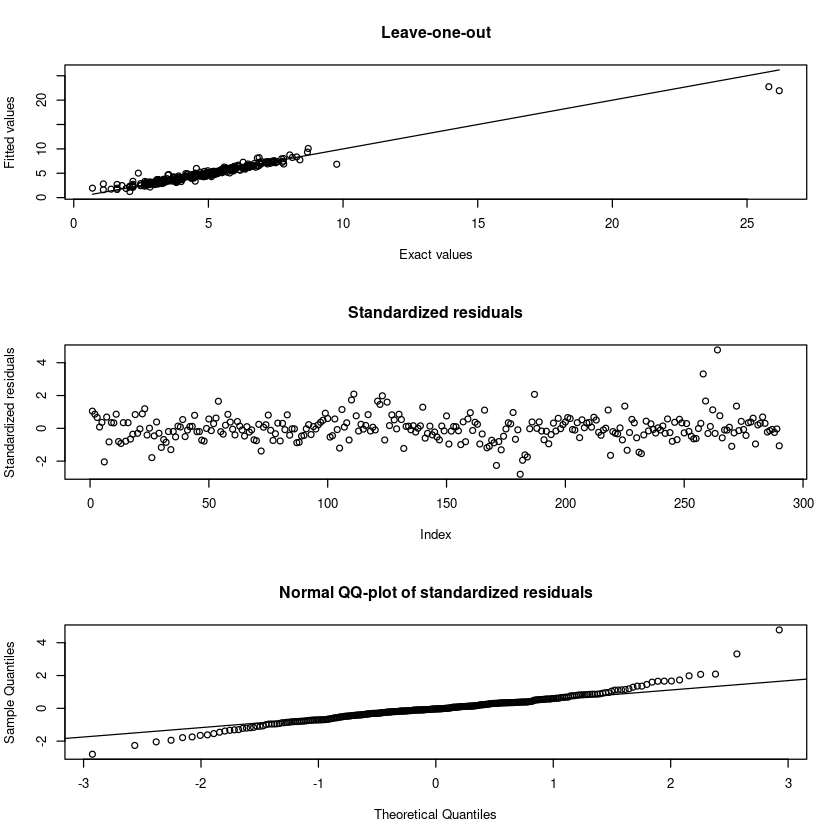

In [13]:
plot(mod)

# Fonction jouet

In [14]:
fjouet<-function(x1, x2){
    if (x2==1-x1){return((x1-0.5)**2+(x2-0.5)**2)}
    else if(x1<0 || x2<0) {return("Error, x1 and x2 must be positive")}
    else {return("Error: The problem is not define on a simplex, x2 must be equal to 1-x1")}
    
}

fjouet.test<-function(x1, x2){
    return((x1-0.5)**2+(x2-0.5)**2)
}

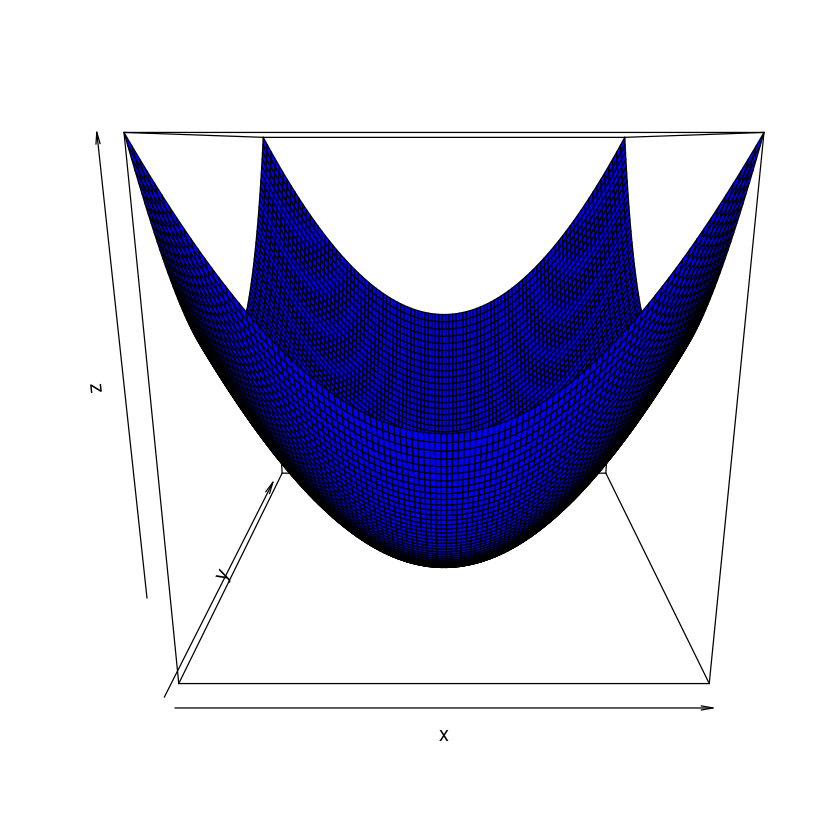

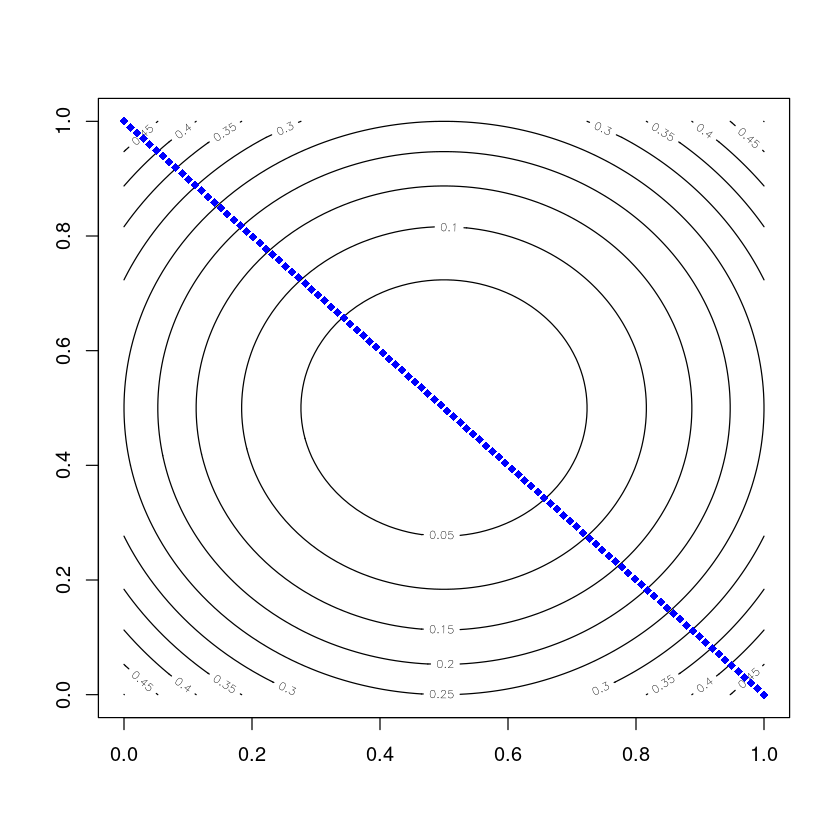

In [15]:
#x = c(0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9) 
#y=1-x

x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)

persp(x,y,z, col='blue')
contour(x,y,z)
lines(x, 1-x, pch=18, col="blue", type="b", lty=2)

In [16]:
#On va tester notre fonction jouet on sait que si on prend x1= 0.2 et x2=1-x2=0.8 on a la target égale à 0.18:
jouet<-fjouet(0.2, 0.8)
jouet

[1] 0.18

In [17]:
test_change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    Y<-sqrt(x) #We do a first change of variables y²=x eq y=sqrt(x)
     #If we have some Nan in our matrix we replace them by zeros
    return(t(as.matrix(rect2polar((t(Y)))$phi)))
}

In [18]:
test_change_in_x_from_phi = function(phi){ #We put in argumennt a matrix or a vector that takes n-1 values of angles in [0, pi/2]
    Phi=as.matrix(phi)
    r=rep(1,dim(Phi)[1])  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, t(Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)
    new[which(new<1e-4)]<-0   #We obtain sometimes values of order 1e-5 we replace it by 0
    return (as.matrix(new*100))
}

In [19]:
test_change_in_lambda_from_x = function(x){ 
    X<-as.matrix(x)
    Phi<-test_change_in_phi_from_x(X) #We change our variables from the simplex in angles in [0, pi/2 ]
    lambda<-(cos(Phi))**2 # We change of varaible is the following : lambda=cos(theta)
    return(lambda)
}

In [20]:
test_change_in_x_from_lambda = function(lambda){ #We put in argument a matrix or a vector of n-1 variables in an hypercube
    Lambda<-as.matrix(lambda) 
    Phi<-acos(sqrt(Lambda)) #We change our variables from the hypercube to the N-spheres so n-1 angles in [0, pi/2]
    return(change_in_x_from_phi(Phi)) #We use the change of variables from a N-sphere to a simplex
}

In [23]:
eps=1e-3
data = c(0.3, 0.7)
d = 2
N = 10*d

x <- seq(eps,1-eps,length.out=100)
y <- 1-x


donne <- cbind(x,y)
resp<- fjouet.test(donne[,1], donne[,2])
mat.donne<-as.data.frame(cbind(resp, donne))

mat.donne



data.change.var <- test_change_in_lambda_from_x(mat.donne[1:N,-1])
data.change.var

data.change.var=as.data.frame(cbind(mat.donne[1:N,1],data.change.var))

mod = km(formula = ~1, design = as.data.frame(data.change.var[,-1]), response = as.data.frame(data.change.var[,1]))

lowerbound = as.vector(rep(0, 1))
upperbound = as.vector(rep(1, 1))


resp,x,y
<dbl>,<dbl>,<dbl>
0.49800200,0.00100000,0.9990000
0.47808395,0.01108081,0.9889192
0.45857240,0.02116162,0.9788384
0.43946733,0.03124242,0.9687576
0.42076875,0.04132323,0.9586768
0.40247667,0.05140404,0.9485960
0.38459108,0.06148485,0.9385152
0.36711197,0.07156566,0.9284343
0.35003936,0.08164646,0.9183535


0.00100000
0.01108081
0.02116162
0.03124242
0.04132323
0.05140404
0.06148485
0.07156566
0.08164646
0.09172727
0.10180808



optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  0.3830707 
  - best initial criterion value(s) :  132.7466 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -132.75  |proj g|=      0.01067
At iterate     1  f =      -133.52  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -133.517

F = -133.517
final  value -133.517422 
converged


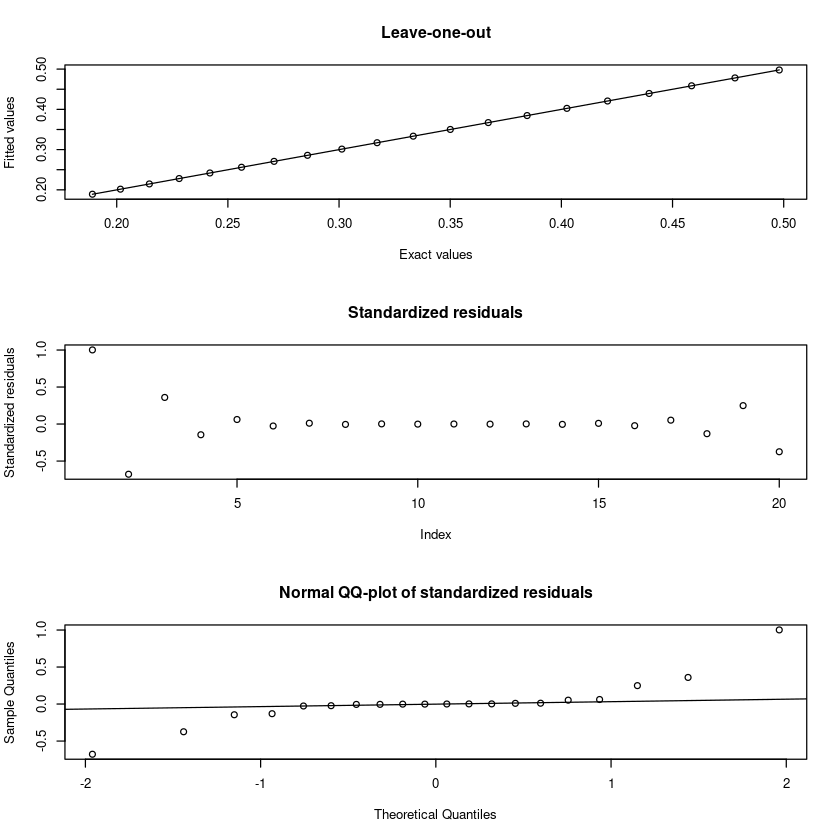

In [24]:
plot(mod)

In [25]:
eps <- 1e-3
theta=max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=0.02)$par
#optimcontrol <- list(method="genoud",pop.size=50)



Tue May 17 19:50:38 2022
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	2.248933e-02
      1 	2.249418e-02
      2 	2.249426e-02

'wait.g

In [26]:
fun <- function(lambda){
    x <- test_change_in_x_from_lambda(lambda)
    fjouet.test(x[1], x[2])
}

In [27]:
optimcontrol <- list(method="genoud",pop.size=50)
obj2 <- EGI(T=0.02, model=mod, method="tmse", iter=10, fun = fun,lower=lowerbound, upper=upperbound ,optimcontrol=optimcontrol)  #il faut retrouver 0.2 et 0.8



Tue May 17 19:50:45 2022
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	2.248933e-02
      1 	2.249418e-02
      2 	2.249426e-02

'wait.g

In [28]:
obj2$par
obj2$value

data.change.var....1.
0.5897534
0.9342186
0.3989440
0.5990511
0.4577023
0.7013804
0.4000274
0.5264043
0.3353599
0.6344309


"data.change.var[, 1]"
0.016111345
0.377091604
0.020424613
0.019622247
0.003578185
0.081108133
0.019989058
0.001394378
0.054212701
0.036143317


[1] 3.749399e-33 5.263158e-02 1.052632e-01 1.578947e-01 2.105263e-01
 [6] 2.631579e-01 3.157895e-01 3.684211e-01 4.210526e-01 4.736842e-01
[11] 5.263158e-01 5.789474e-01 6.315789e-01 6.842105e-01 7.368421e-01
[16] 7.894737e-01 8.421053e-01 8.947368e-01 9.473684e-01 1.000000e+00

[1]  1 20

[1] 0.500000000 0.400277008 0.311634349 0.234072022 0.167590028 0.112188366
 [7] 0.067867036 0.034626039 0.012465374 0.001385042 0.001385042 0.012465374
[13] 0.034626039 0.067867036 0.112188366 0.167590028 0.234072022 0.311634349
[19] 0.400277008 0.500000000

[1] 20

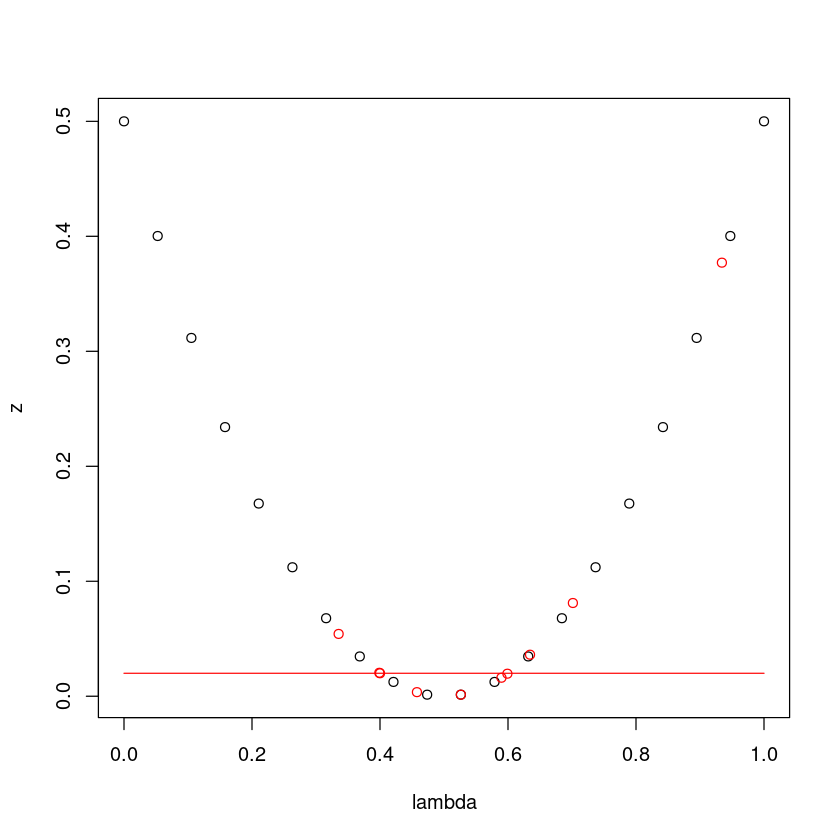

In [29]:
x <- seq(0,1,length.out=20)
y <- 1-x
donne=cbind(x,y)
lambda=t(test_change_in_lambda_from_x(donne))
sort(lambda)
dim(lambda)
z=fjouet.test(donne[,1], donne[,2])
z
length(z)
plot(lambda,z)
points(obj2$par[,1],obj2$value[,1], col="red")
lines(x=seq(0,1,length.out=100),rep(0.02, 100), col="red")

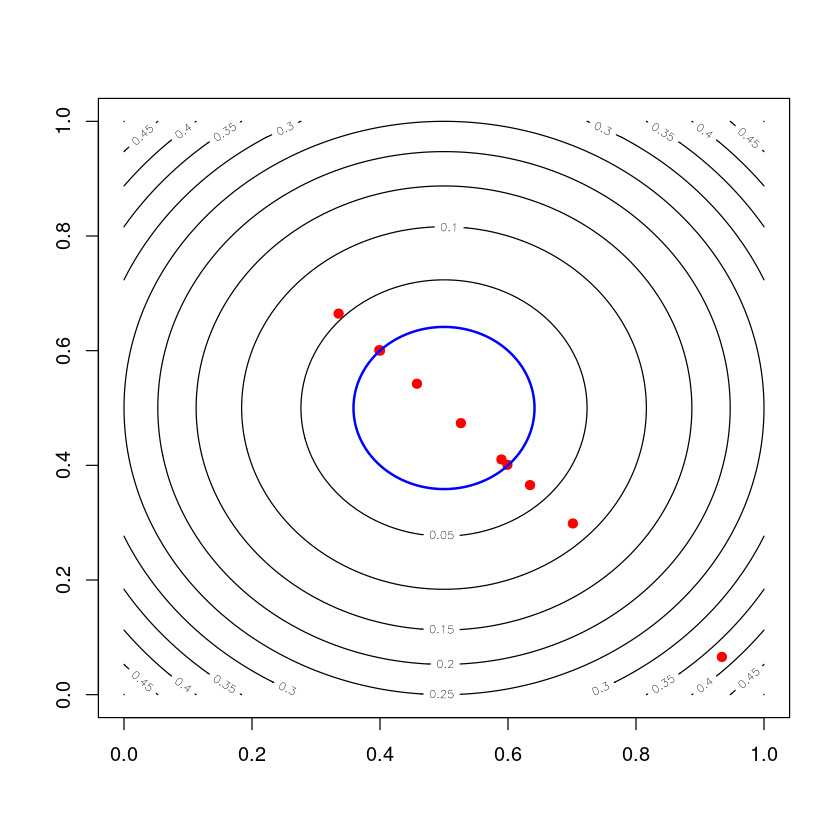

In [30]:
x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)
contour(x,sort(y),z)
change=test_change_in_x_from_lambda(obj2$par)
points(change[,1], change[,2], pch=19, col="red")
theta=seq(0,2*pi, length=200)
lines(0.5+sqrt(0.02)*cos(theta), 0.5+sqrt(0.02)*sin(theta), col="blue", lwd=2)

In [31]:
obj3 <- EGI(T=0.0578, model=mod, method="tmse", iter=10, fun = fun, 
           lower=eps, upper=1 - eps, optimcontrol=optimcontrol)  #il faut retrouver 0.33 et 0.67



Tue May 17 19:50:59 2022
Domains:
 1.000000e-03   <=  X1   <=    9.990000e-01 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	3.154478e-02
      1 	3.154579e-02
      2 	3.154586e-02
      3 

In [32]:
obj3$par
obj3$value

data.change.var....1.
0.5868050
0.9188544
0.6543418
0.3462509
0.3292517
0.6688208
0.4605464
0.7575640
0.9989999
0.3996857


"data.change.var[, 1]"
0.015070225
0.350878066
0.047642789
0.047277554
0.058309992
0.057000957
0.003113179
0.132678440
0.498001861
0.020125925


[1] 3.749399e-33 5.263158e-02 1.052632e-01 1.578947e-01 2.105263e-01
 [6] 2.631579e-01 3.157895e-01 3.684211e-01 4.210526e-01 4.736842e-01
[11] 5.263158e-01 5.789474e-01 6.315789e-01 6.842105e-01 7.368421e-01
[16] 7.894737e-01 8.421053e-01 8.947368e-01 9.473684e-01 1.000000e+00

[1]  1 20

[1] 0.500000000 0.400277008 0.311634349 0.234072022 0.167590028 0.112188366
 [7] 0.067867036 0.034626039 0.012465374 0.001385042 0.001385042 0.012465374
[13] 0.034626039 0.067867036 0.112188366 0.167590028 0.234072022 0.311634349
[19] 0.400277008 0.500000000

[1] 20

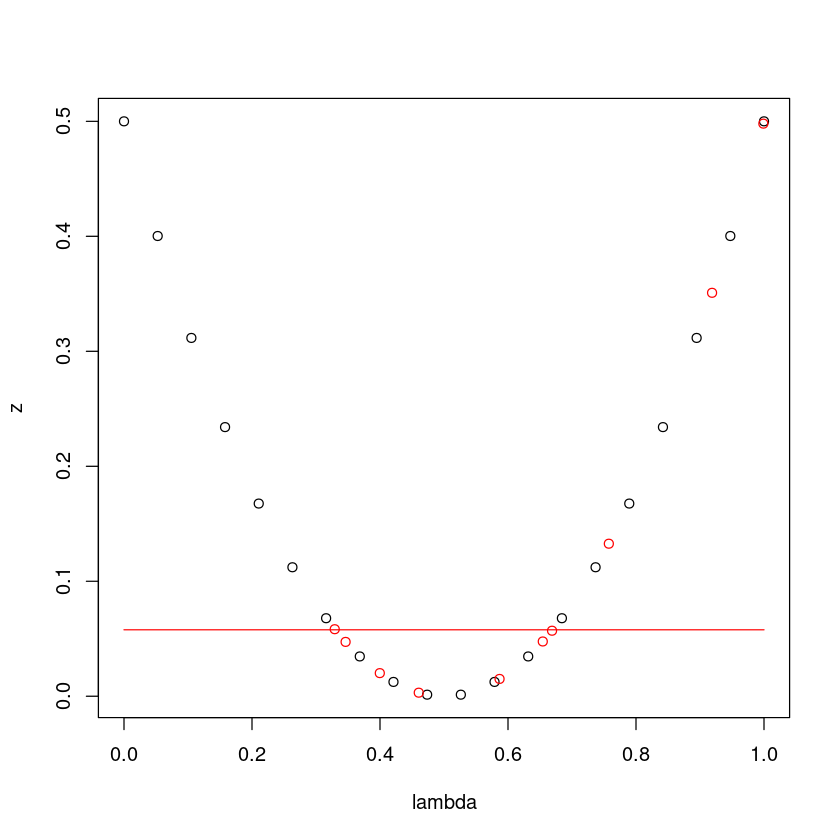

In [33]:
x <- seq(0,1,length.out=20)
y <- 1-x
donne=cbind(x,y)
lambda=t(test_change_in_lambda_from_x(donne))
sort(lambda)
dim(lambda)
z=fjouet.test(donne[,1], donne[,2])
z
length(z)
plot(lambda,z)
points(obj3$par[,1],obj3$value[,1], col="red")
lines(x=seq(0,1,length.out=100),rep(0.0578, 100), col="red")

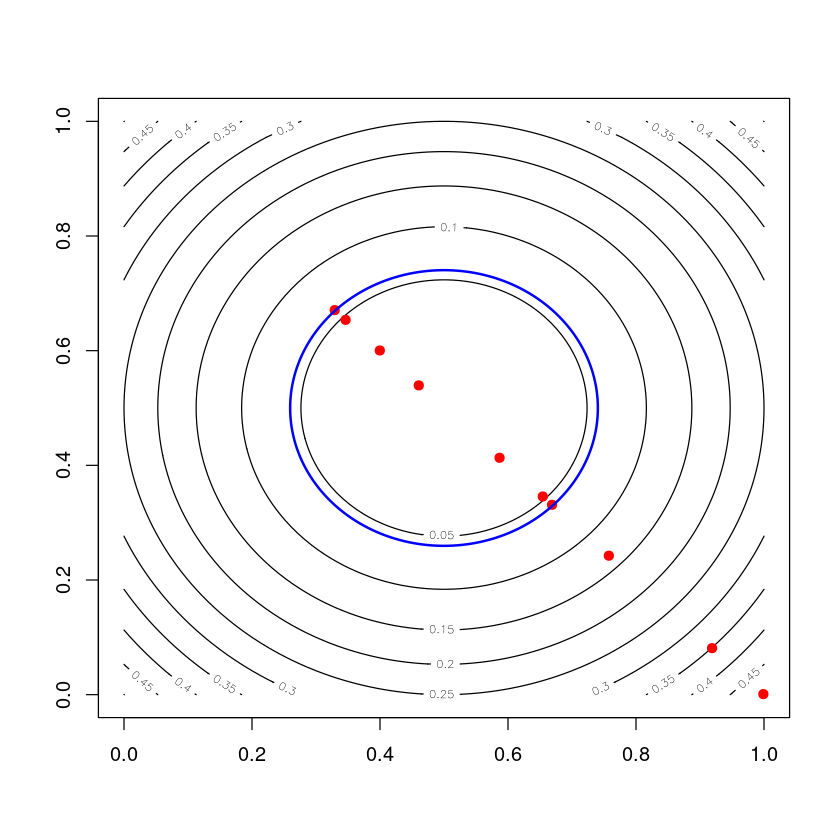

In [34]:
x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)
contour(x,sort(y),z)
change3=test_change_in_x_from_lambda(obj3$par)
points(change3[,1], change3[,2], pch=19, col="red")
theta=seq(0,2*pi, length=200)
lines(0.5+sqrt(0.0578)*cos(theta), 0.5+sqrt(0.0578)*sin(theta), col="blue", lwd=2)

In [35]:
#en dimension 2

d = 2
N = 10*d

x <- runif(N)
y <- runif(N)


donne <- cbind(x,y)
resp<- fjouet.test(donne[,1], donne[,2])
mat.donne<-as.data.frame(cbind(resp, donne))


data.var <- mat.donne[1:N, ]


mod = km(formula = ~1, design = as.data.frame(data.var[,-1]), response = as.data.frame(data.var[,1]))


eps = 1e-3
lowerbound = as.vector(rep(eps, dim(data.var[,-1])[2]))
upperbound = as.vector(rep(1-eps, dim(data.var[,-1])[2]))


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  1.748037 1.890122 
  - best initial criterion value(s) :  58.22852 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -58.229  |proj g|=     0.048938
At iterate     1  f =      -58.508  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -58.5084

F = -58.5084
final  value -58.508358 
converged


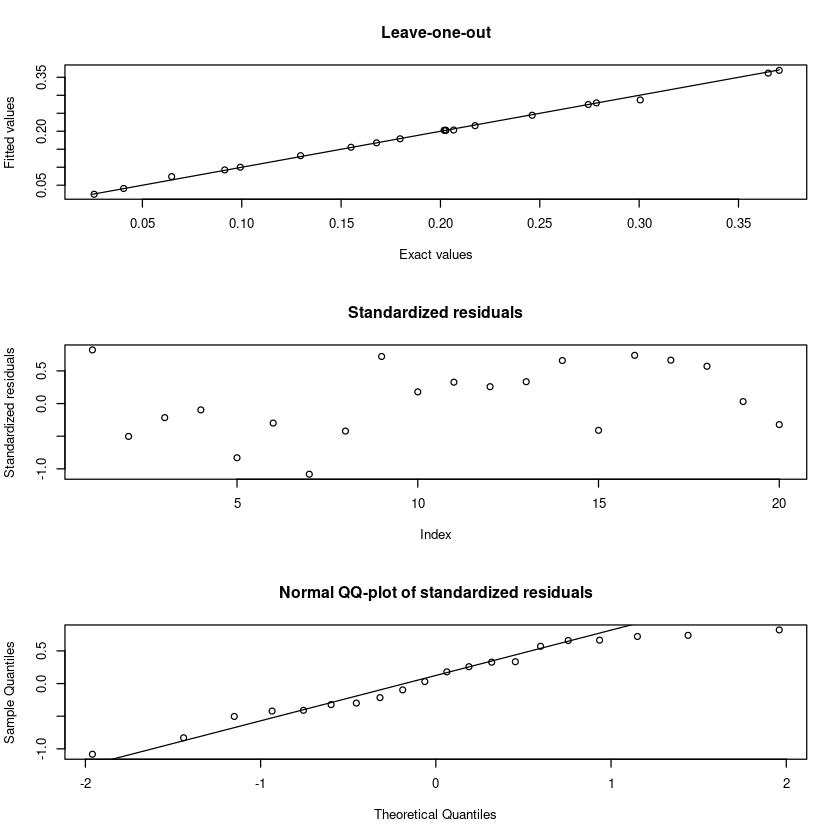

In [36]:
plot(mod)

In [37]:
fun2 <- function(x){
    return(fjouet.test(x[1], x[2]))
}

In [38]:
optimcontrol <- list(method="tmse",pop.size=50*2,max.generations =10*2)
obj4 <- EGI(T=0.18,model=mod, method="tmse",iter=10,fun = fun2,lower=lowerbound, upper=upperbound,optimcontrol=optimcontrol) 



Tue May 17 19:51:14 2022
Domains:
 1.000000e-03   <=  X1   <=    9.990000e-01 
 1.000000e-03   <=  X2   <=    9.990000e-01 

NOTE: The total number of operators greater than population size
NOTE: I'm increasing the population size to 104 (operators+2).

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	25
	(6) Simple Crossover.................. 	26
	(7) Whole Non-Uniform Mutation........ 	25
	(8) Heuristic Crossover............... 	26
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 20
Maximum Nonchanging Generations: 2
Population size       : 104
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bound

Warning message in genoud(fn = funk.optim, nvars = d, max = TRUE, pop.size = optimcontrol$pop.size, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 1.290661e-04

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.483685e-02	G[ 1] :	-2.487393e-04
 X[ 2] :	5.871810e-01	G[ 2] :	-2.624783e-04

Solution Found Generation 20
Number of Generations Run 20

Tue May 17 19:51:20 2022
Total run time : 0 hours 0 minutes and 2 seconds
[1] "New point"
              x        y
[1,] 0.08483685 0.587181

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  1.748037 1.890122 
  - best initial criterion value(s) :  102.8854 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -102.89  |proj g|=       0.2816
At iterate     1  f =      -105.62  |proj g|=             0

iterations 1
function

In [40]:
obj4$par

,x,y
X,0.90478890,0.3478984
X.1,0.45441605,0.9167097
X.2,0.11552390,0.6734725
X.3,0.80505048,0.2032561
X.4,0.72994970,0.8532941
X.5,0.07588402,0.4957114
X.6,0.23019827,0.8270265
X.7,0.85582816,0.2699720
X.8,0.08483685,0.5871810
X.9,0.92445519,0.5145975


In [41]:
obj4$val

"data.var[, 1]"
0.1869890
0.1757249
0.1779146
0.1811127
0.1776936
0.1798928
0.1797393
0.1795266
0.1799610
0.1803753


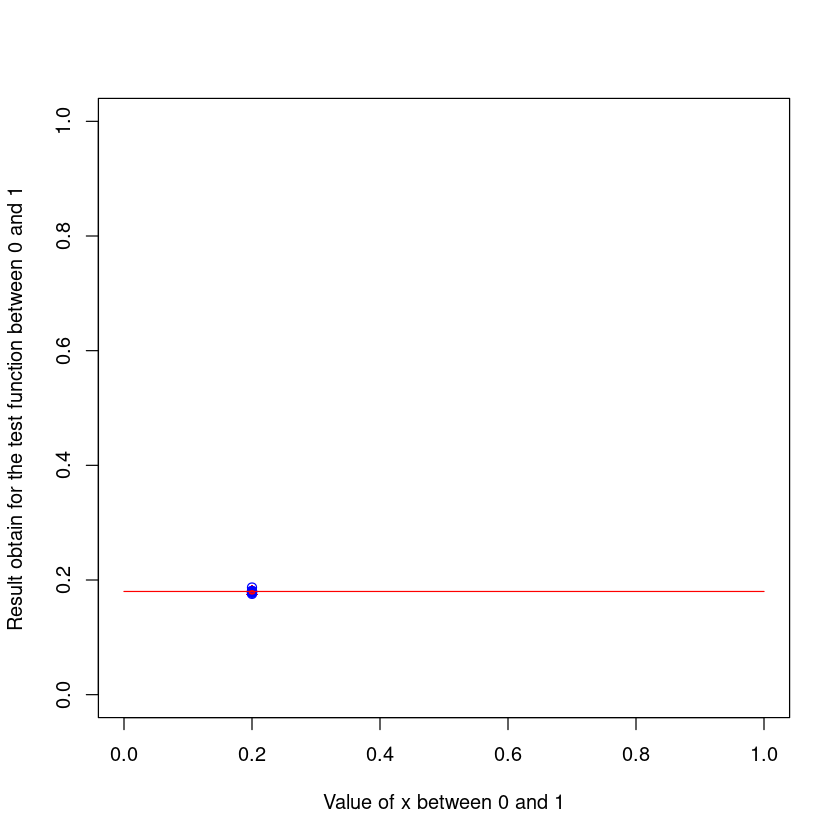

In [42]:
plot(0.2, 0.18, col="red", pch = 17,xlim=c(0,1), ylim=c(0,1),xlab="Value of x between 0 and 1",
        ylab="Result obtain for the test function between 0 and 1",)
points(rep(0.2, dim(obj4$val)[1]), obj4$val, col="blue")
lines(x=seq(0,1,length.out=100),rep(0.18, 100), col="red")

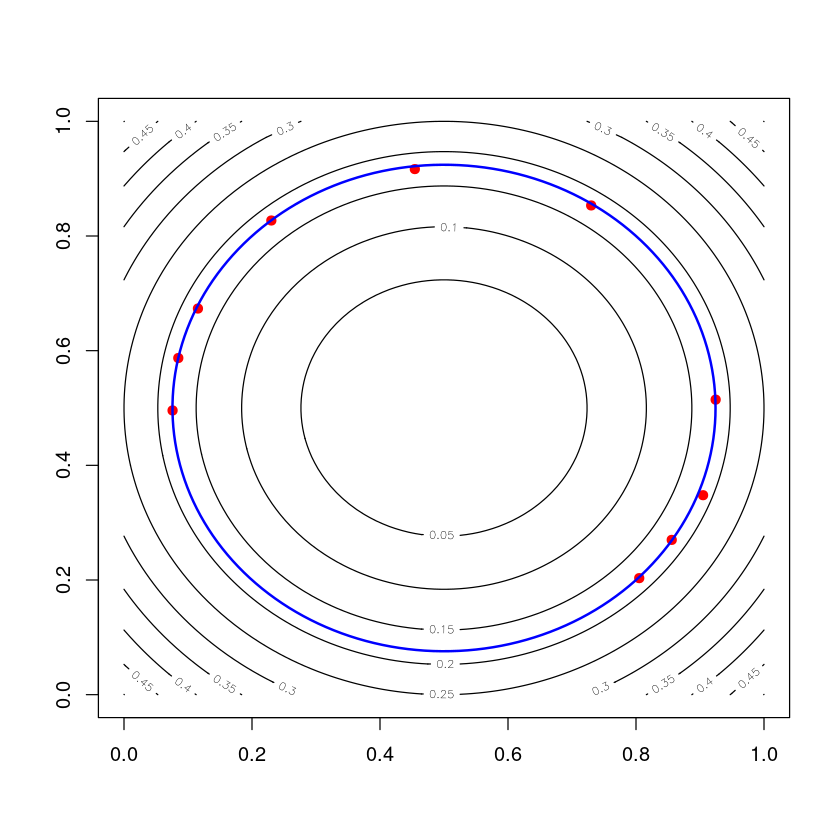

In [43]:
x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)
contour(x,sort(y),z)
points(obj4$par[,1], obj4$par[,2], pch=19, col="red")
theta=seq(0,2*pi, length=200)
lines(0.5+sqrt(0.18)*cos(theta), 0.5+sqrt(0.18)*sin(theta), col="blue", lwd=2)